In [ ]:
# library import

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

### numpy 구현(안할래)

In [ ]:
# input

batch_size = 32
seq_length = 12
embedding_size = 512
d_model = embedding_size
head = 8

input_emb = np.random.randn(batch_size, seq_length, embedding_size)
input_emb.dtype

dtype('float64')

In [ ]:
# Positional Encoding

class Positional_Encoding:
  def __init__(self,batch_size, seq_length, d_model):
    self.pos_encoding = self.positional_encoding(batch_size, seq_length, d_model)

  def get_angle(self, pos, i, d_model):
    angle = 1/np.power(10000,2*(i//2)/d_model)
    return pos * angle

  def positional_encoding(self,batch_size, seq_length, d_model):
    pos_encode = self.get_angle(pos = np.arange(seq_length, dtype=np.float32).reshape(1,-1,1).repeat(batch_size, axis=0),
                                i = np.arange(d_model, dtype=np.float32).reshape(1,1,-1).repeat(batch_size, axis=0),
                                d_model = d_model)
    pos_encode[:,:,0::2] = np.sin(pos_encode[:,:,0::2])
    pos_encode[:,:,1::2] = np.cos(pos_encode[:,:,1::2])
    return pos_encode

  def forward(self, input):
    return input + self.pos_encoding

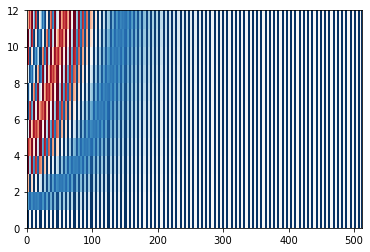

In [ ]:
PE = Positional_Encoding(batch_size, seq_length, d_model)
input_pos = PE.forward(input_emb)

pos = PE.pos_encoding[0]
plt.pcolormesh(pos, cmap='RdBu')
plt.show()

In [ ]:
# Self Attention

def Scaled_dot_product_attention(V, K, Q, masking = False):
  d_k = d_model//head
  QK_scaled = np.dot(Q, K.transpose(0,2,1)) / np.sqrt(d_k)

## pytorch 구현

https://github.com/hyunwoongko/transformer  

https://arxiv.org/pdf/1706.03762.pdf

In [ ]:
# input

batch_size = 32
seq_len = 20
max_len = 512
embedding_size = 512

d_model = embedding_size
n_head = 8

input = torch.rand(size = (batch_size, seq_len, d_model), dtype=torch.float)
input.size()

torch.Size([32, 20, 512])

### Token Embedding

In [ ]:
# Token Embedding

class Token_Embedding(nn.Embedding):
  def __init__(self, vocab_size, d_model):
    super(Token_Embedding, self).__init__(vocab_size, d_model, padding_idx =1)

### Positional Encoding

In [ ]:
# Positional Encoding

class Positional_Encoding(nn.Module):
  def __init__(self, max_len, d_model):
    super(Positional_Encoding, self).__init__()
    self.pos_encoding = self.positional_encoding(max_len, d_model)

  def get_angle(self, pos, i, d_model):
    angle = 1/np.power(10000,2*(i//2)/d_model)
    return pos * angle

  def positional_encoding(self, max_len, d_model):
    pos = self.get_angle(pos = torch.arange(0, max_len, dtype=torch.float32).view(-1,1),
                         i = torch.arange(0, d_model, dtype=torch.float32).view(1,-1),
                         d_model = d_model)
    pos[:,0::2] = torch.sin(pos[:,0::2])
    pos[:,1::2] = torch.cos(pos[:,1::2])
    return pos

  def forward(self, input):
    batch_size, seq_len, d_model = input.size()
    return self.pos_encoding[:seq_len,:]


In [ ]:
PE = Positional_Encoding(max_len, d_model)
input_pos = PE(input)
input_pos.size()

torch.Size([20, 512])

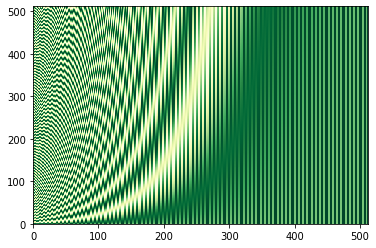

In [ ]:
plt.pcolormesh(PE.pos_encoding.numpy(), cmap='YlGn')
plt.show()

### Embedding Layer

In [ ]:
# Transformer Embedding

class Transformer_Embedding(nn.Module):
  def __init__(self, vocab_size, max_len, d_model, drop_rate):
    super(Transformer_Embedding, self).__init__()
    self.tok_embedding = Token_Embedding(vocab_size, d_model)
    self.pos_embedding = Positional_Encoding(max_len, d_model)
    self.dropout = nn.Dropout(drop_rate)

  def forward(self, x):
    tok_emb = self.tok_embedding(x)
    pos_emb = self.pos_embedding(x)
    return self.drop_out(tok_emb + pos_emb)

### Multi-head Attention

In [ ]:
# Self_attention

class Self_Attention(nn.Module):
  def __init__(self):
    super(Self_Attention, self).__init__()
    # dim=-1 : last dimension, dim 방향으로 sum 했을때 1로 기억하자
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, Q, K, V, mask=None):
    # input : (batch_size, n_head, seq_len, d_k)
    # output : (batch_size, n_head, seq_len, d_k)
    batch_size, head, seq_len, d_k = K.size()
    # dot product
    K_t = K.transpose(2,3)
    score = Q @ K_t / np.sqrt(d_k)
    # masking
    if mask is not None:
      score = score.masked_fill(mask==0, -10000)
    # softmax
    score = self.softmax(score)
    # multiply V
    V  = score @ V
    return V, score

class MultiHead_Attention(nn.Module):
  def __init__(self, d_model, n_head):
    super(MultiHead_Attention, self).__init__()
    self.n_head = n_head
    self.attention = Self_Attention()
    self.W_Q = nn.Linear(d_model, d_model)
    self.W_K = nn.Linear(d_model, d_model)
    self.W_V = nn.Linear(d_model, d_model)
    self.W_concat = nn.Linear(d_model, d_model)

  def split(self, tensor):
    # input : (batch_size, seq_len, d_model)
    # output : (batch_size, n_head, seq_len, d_k)
    batch_size, seq_len, d_model = tensor.size()

    d_k = d_model//self.n_head
    tensor = tensor.view(batch_size, seq_len, self.n_head, d_k).transpose(1,2)
    return tensor

  def concat(self, tensor):
    # input : (batch_size, n_head, seq_len, d_k)
    # output : (batch_size, seq_len, d_model)
    batch_size, n_head, seq_len, d_k = tensor.size()

    d_model = n_head * d_k
    # transpose, view로만 변환시킬 경우 기존텐서와 메모리를 공유하고 모양만 변함
    # 주소값 연속성이 불변인 것이 문제, contiguous로 새로운 공간에 데이터 복사
    tensor = tensor.transpose(1,2).contiguous().view(batch_size, seq_len, d_model)
    return tensor

  def forward(self, Q, K, V, mask=None):
    # dot product
    Q,K,V = self.W_Q(Q), self.W_Q(Q), self.W_Q(Q)
    # split tensor by n_head
    Q,K,V = self.split(Q),self.split(K),self.split(V)
    # scale dot product attention
    out, attention = self.attention(Q,K,V,mask=mask)
    # out : (batch_size, n_head, seq_len, d_k), attention : (batch_size, n_head, seq_len, seq_len)
    out = self.concat(out)
    out = self.W_concat(out)
    return out


In [ ]:
MHA = MultiHead_Attention(d_model, n_head)
MHA(input_pos,input_pos,input_pos).size()
x = MHA(input_pos,input_pos,input_pos)

### Layer Normalization

In [ ]:
# Layer Norm
class Layer_Normalization(nn.Module):
  def __init__(self, d_model, eps = 1e-12):
    super(Layer_Normalization, self).__init__()
    self.gamma = nn.Parameter(torch.ones(d_model))
    self.beta = nn.Parameter(torch.zeros(d_model))
    self.eps = eps

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)

    out = (x-mean) / torch.sqrt(var + self.eps)
    out = self.gamma * out + self.beta
    return out

In [ ]:
print(x)
LN = Layer_Normalization(d_model)
x_n = LN(x)
x_n

### Feed-Forward Network

In [ ]:
# FFN

class Feed_Forward_Network(nn.Module):
  def __init__(self, d_model, hidden, drop_rate = 0.1):
    super(Feed_Forward_Network, self).__init__()
    self.linear1 = nn.Linear(d_model, hidden)
    self.linear2 = nn.Linear(hidden, d_model)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p = drop_rate)

  def forward(self, x):
    out = self.linear1(x)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.linear2(out)
    return out

In [ ]:
ffn_hidden = 512
FFN = Feed_Forward_Network(d_model, hidden=ffn_hidden)
out = FFN(x_n)
out.size()

torch.Size([32, 20, 512])

### Encoder Layer

In [ ]:
# Encoder Layer

class Encoder_Layer(nn.Module):
  def __init__(self, d_model, ffn_hidden, n_head, drop_rate):
    super(Encoder_Layer, self).__init__()
    self.attention = MultiHead_Attention(d_model, n_head)
    self.layer_norm1 = Layer_Normalization(d_model)
    self.dropout1 = nn.Dropout(drop_rate)
    self.ffn = Feed_Forward_Network(d_model, ffn_hidden, drop_rate)
    self.layer_norm2 = Layer_Normalization(d_model)
    self.dropout2 = nn.Dropout(drop_rate)

  def forward(self, x, src_mask):
    x0 = x
    x = self.attention(x,x,x,src_mask)
    x = self.dropout1(x)
    x = self.layer_norm1(x+x0)

    x0 = x
    x = self.ffn(x)
    x = self.dropout1(x)
    x = self.layer_norm2(x+x0)
    return x

In [ ]:
# Encoder

class Encoder(nn.Module):
  def __init__(self, enc_voc_size, max_len, d_model,
               ffn_hidden, n_head, n_layers, drop_rate, device):
    self.embedding = Transformer_Embedding(enc_voc_size, max_len, d_model, drop_rate)
    self.layers = nn.ModuleList(
        [Encoder_Layer(d_model, ffn_hidden, n_head, drop_rate) for _ in range(n_layers)])

  def forward(self, x, src_mask):
    x = self.embedding(x)
    for layer in self.layers:
      x = layer(x, src_mask)
    return x

### Decoder Layer

In [ ]:
# Decoder Layer

class Decoder_Layer(nn.Module):
  def __init__(self, d_model, ffn_hidden, n_head, drop_rate):
    super(Decoder_Layer, self).__init__()
    self.self_attention = MultiHead_Attention(d_model, n_head)
    self.layer_norm1 = Layer_Normalization(d_model)
    self.dropout1 = nn.Dropout(drop_rate)

    self.enc_dec_attention = MultiHead_Attention(d_model, n_head)
    self.layer_norm2 = Layer_Normalization(d_model)
    self.dropout2 = nn.Dropout(drop_rate)

    self.ffn = Feed_Forward_Network(d_model, ffn_hidden, drop_rate)
    self.layer_norm3 = Layer_Normalization(d_model)
    self.dropout3 = nn.Dropout(drop_rate)

  def forward(self, x_dec, x_enc, trg_mask, src_mask):
    x_dec0 = x_dec
    x_dec = self.self_attention(x_dec, x_dec, x_dec, trg_mask)
    x_dec = self.dropout1(x_dec)
    x = self.layer_norm1(x_dec + x_dec0)

    if x_enc is not None:
      x0 = x
      x = self.enc_dec_attention(Q=x, K=x_enc, V=x_enc, mask=src_mask)
      x = self.dropout1(x)
      x = self.layer_norm1(x + x_dec0)

    x0 = x
    x = self.ffn(x)
    x = self.dropout3(x)
    x = self.layer_norm3(x+x0)
    return x

In [ ]:
# Decoder

class Decoder(nn.Module):
  def __init__(self, dec_voc_size, max_len, d_model,
               ffn_hidden, n_head, n_layers, drop_rate, device):
    super(Decoder, self).__init__()
    self.embedding = Transformer_Embedding(dec_voc_size, max_len, d_model, drop_rate)
    self.layers = nn.ModuleList([Decoder_Layer(d_model,
                                               ffn_hidden, n_head, drop_rate) for _ in range(n_layers)])
    self.linear = nn.Linear(d_model, dec_voc_size)

  def forward(self, x_dec, x_enc, trg_mask, src_mask):
    x_dec = self.embedding(x_dec)
    for layer in self.layers:
      x_dec = layer(x_dec, x_enc, trg_mask, src_mask)

    out = self.linear(x)
    return out

### Transformer

In [ ]:
# Transformer

# 여기부터 다시 해보자